# Face Detection and Calculation in Images

by Nan BAI

adapted from the original code of facenet-pytorch library

In [114]:
from facenet_pytorch import MTCNN, InceptionResnetV1
import torch
from torch.utils.data import DataLoader
from torchvision import datasets
from torch.autograd import Variable as V
from torchvision import transforms as trn
from torch.nn import functional as F
import numpy as np
import pandas as pd
import os
from PIL import Image, ImageDraw
from PIL.ImageOps import colorize
from IPython import display

workers = 0 if os.name == 'nt' else 4

In [34]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Running on device: {}'.format(device))

Running on device: cuda:0


In [3]:
mtcnn = MTCNN(
    image_size=160, margin=0, min_face_size=20,
    thresholds=[0.6, 0.7, 0.7], factor=0.709, post_process=True,
    device=device
)

In [4]:
resnet = InceptionResnetV1(pretrained='vggface2').eval().to(device)

In [5]:
def returnTF():
# load the image transformer
    tf = trn.Compose([
        trn.Resize((150,150)),
        trn.ToTensor(),
        #trn.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    return tf

In [6]:
def load_images(images_folder):
    all_images = []
    for file in os.listdir(images_folder):
        if os.path.splitext(file)[1].lower() in ('.jpg', '.jpeg', '.png'):
            all_images.append(file)
    return all_images

In [7]:
images_folder = 'Venezia/data_storage/images/150/'
all_images = load_images(images_folder)

In [27]:
images_folder_Suzhou = 'Suzhou/data_storage/images/150/'
all_images_Suzhou = load_images(images_folder_Suzhou)

In [35]:
images_folder_large = 'data_storage/images/grid-150/'
all_images_large = load_images(images_folder_large)

In [102]:
def get_one_image(ID = 0, all_images=all_images, images_folder=images_folder):
    # load the test image
    img_name = all_images[ID]
    #os.system('wget %s -q -O test.jpg' % img_url)
    img = Image.open(images_folder + img_name)
    if img.mode == 'L':
        img = colorize(img, black=(0,0,0), white=(255,255,255))
    if img.mode == 'CMYK':
        img = img.convert('RGB')
    if not img.mode == 'RGB':
        img = img.convert('RGB')
    tf = returnTF()
    input_img = V(tf(img).permute(1,2,0).unsqueeze(0))
    img = img.resize((150,150))
    return img_name, img, input_img*255

In [103]:
def get_one_image_name(name, all_images=all_images, images_folder=images_folder):
    assert name+'.jpg' in all_images
    img = Image.open(images_folder + name + '.jpg')
    if img.mode == 'L':
        img = colorize(img, black=(0,0,0), white=(255,255,255))
    tf = returnTF()
    input_img = V(tf(img).permute(1,2,0).unsqueeze(0))
    img = img.resize((150,150))
    return img, input_img*255

In [10]:
def process_one_image(img, input_img, model=mtcnn):
    boxes, prob = mtcnn.detect(input_img)
    for i in range(len(boxes)):
        if len(prob[i])<=1:
            if not prob[i][0]:
                boxes[i] = []
                prob[i] = [0]
    return boxes, prob

In [11]:
def draw_one_image(img, input_img, model=mtcnn):
    boxes, prob = process_one_image(img, input_img, model=model)
    frame = img.copy()
    frame_draw = frame.copy()
    draw = ImageDraw.Draw(frame_draw)
    for box in boxes[0]:
        draw.rectangle(box.tolist(), outline=(255, 0, 0), width=3)
        
    # Add to frame list
    frames_draw = frame_draw.resize((150, 150), Image.BILINEAR)
    d = display.display(frames_draw, display_id=True)

In [12]:
def get_areas(boxes):
    areas = []
    for box in boxes:
        area = (box[2]-box[0])*(box[3]-box[1])
        areas.append(area)
    return np.array(areas).sum(),areas

In [13]:
def report_one_image(img, input_img, model=mtcnn):
    boxes, prob = process_one_image(img, input_img, model=model)
    report = {}
    report['prob'] = prob[0]
    report['boxes'] = boxes
    report['num_faces'] = len(boxes)
    area, areas = get_areas(boxes)
    report['area'] = area
    report['areas'] = areas
    report['ratio'] = area/(img.size()[0]*img.size()[1])
    return report

In [14]:
def report_many_images(img, input_img, image_names, model=mtcnn):
    if len(image_names)==1:
        return report_one_image(img, input_img, model=model)
    
    boxes, prob= process_one_image(img, input_img, model)
    all_report = {}
    
    for n in range(len(image_names)):
        report = {}
        report['Face_prob'] = prob[n][0]
        report['Face_boxes'] = boxes[n]
        report['Face_num_faces'] = len(boxes[n])
        area, areas = get_areas(boxes[n])
        report['Face_area'] = area
        report['Face_areas'] = areas
        report['Face_ratio'] = area/(img[n].size()[0]*img[n].size()[1])
        
        all_report[image_names[n][:-4]] = report

    return all_report

In [112]:
def report_images(IDs=[0,1], images_folder=images_folder, all_images=all_images, model=mtcnn):
    image_names = [get_one_image(ID, all_images, images_folder)[0] for ID in IDs]
    #for ID in IDs:
    #    print(get_one_image(ID, all_images, images_folder)[0], get_one_image(ID, all_images, images_folder)[1])
    imgs = torch.as_tensor(np.stack([get_one_image(ID, all_images, images_folder)[1] for ID in IDs]))
    input_img = torch.cat(tuple([get_one_image(ID, all_images, images_folder)[-1] for ID in IDs]))
    report = report_many_images(imgs, input_img, image_names, model=model)
    return report

In [16]:
def images_to_df(IDs=[0,1], images_folder=images_folder, all_images=all_images, model=mtcnn):
    report = report_images(IDs, images_folder=images_folder, all_images=all_images, model=model)
    image_names = report.keys()
    df_all = pd.DataFrame(report)
    return df_all

In [105]:
def batch_df(images_folder=images_folder, all_images=all_images, batch_size = 8, model=mtcnn, ls_df = []):
    size = len(all_images)
    batch_num = int(size/batch_size)
    #ls_df = []
    for i in range(batch_num):
        IDs = list(range(batch_size*i, batch_size*(i+1)))
        temp_df = images_to_df(IDs, images_folder=images_folder, all_images=all_images, model=model)
        ls_df.append(temp_df.T)
        print('{}/{} batches finished'.format(i+1, batch_num+1))
    IDs = list(range(batch_size*batch_num, size))
    temp_df = images_to_df(IDs, images_folder=images_folder, all_images=all_images, model=model)
    ls_df.append(temp_df.T)
    df_all = pd.concat(ls_df, axis=0)
    return df_all

In [18]:
Face_pred = batch_df(images_folder, all_images,256)

D:\surfdrive\TUD\env\lib\site-packages\facenet_pytorch\models\utils\detect_face.py:183: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  batch_boxes, batch_points = np.array(batch_boxes), np.array(batch_points)
D:\surfdrive\TUD\env\lib\site-packages\facenet_pytorch\models\mtcnn.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  boxes = np.array(boxes)
D:\surfdrive\TUD\env\lib\site-packages\facenet_pytorch\models\mtcnn.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or nd

1/12 batches finished
2/12 batches finished
3/12 batches finished
4/12 batches finished
5/12 batches finished
6/12 batches finished
7/12 batches finished
8/12 batches finished
9/12 batches finished
10/12 batches finished
11/12 batches finished


In [28]:
Face_pred_Suzhou = batch_df(images_folder_Suzhou, all_images_Suzhou,256)

D:\surfdrive\TUD\env\lib\site-packages\facenet_pytorch\models\utils\detect_face.py:183: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  batch_boxes, batch_points = np.array(batch_boxes), np.array(batch_points)
D:\surfdrive\TUD\env\lib\site-packages\facenet_pytorch\models\mtcnn.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  boxes = np.array(boxes)
D:\surfdrive\TUD\env\lib\site-packages\facenet_pytorch\models\mtcnn.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or nd

1/13 batches finished
2/13 batches finished
3/13 batches finished
4/13 batches finished
5/13 batches finished
6/13 batches finished
7/13 batches finished
8/13 batches finished
9/13 batches finished
10/13 batches finished
11/13 batches finished
12/13 batches finished


In [116]:
Face_pred_large = batch_df(images_folder_large, all_images_large,256)

1/317 batches finished
2/317 batches finished
3/317 batches finished
4/317 batches finished
5/317 batches finished
6/317 batches finished
7/317 batches finished
8/317 batches finished
9/317 batches finished
10/317 batches finished
11/317 batches finished
12/317 batches finished
13/317 batches finished
14/317 batches finished
15/317 batches finished
16/317 batches finished
17/317 batches finished
18/317 batches finished
19/317 batches finished
20/317 batches finished
21/317 batches finished
22/317 batches finished
23/317 batches finished
24/317 batches finished
25/317 batches finished
26/317 batches finished
27/317 batches finished
28/317 batches finished
29/317 batches finished
30/317 batches finished
31/317 batches finished
32/317 batches finished
33/317 batches finished
34/317 batches finished
35/317 batches finished
36/317 batches finished
37/317 batches finished
38/317 batches finished
39/317 batches finished
40/317 batches finished
41/317 batches finished
42/317 batches finished
4

In [130]:
Face_pred_large = Face_pred_large.reset_index().drop_duplicates(subset = 'index').set_index('index')

In [20]:
Face_pred.to_csv('Venezia/data_storage/Face_preds.csv',sep='\t')

In [29]:
Face_pred_Suzhou.to_csv('Suzhou/data_storage/Face_preds.csv',sep='\t')

In [131]:
Face_pred_large.to_csv('data_storage/images/Face_preds.csv',sep='\t')

In [21]:
too_much = Face_pred[Face_pred['Face_ratio']>0.1].index

In [22]:
too_much

Index(['50288919153', '50459500487', '50682056742', '50792748806',
       '51066425756', '51336218134', '51337276222', '51537877938',
       '51553784091', '51599380580', '51642717687', '51644506601',
       '51644727818', '51645360890', '51645361290', '51645612563',
       '51674640513', '51677867202', '51678671161', '51678671571',
       '51678671651', '51692043547', '51698003645', '51727987812',
       '51832765717', '51865492696', '51870380541'],
      dtype='object')

In [23]:
len(too_much)

27

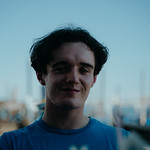

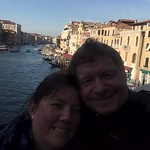

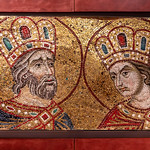

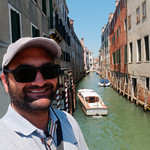

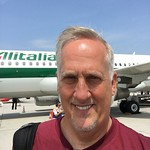

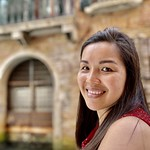

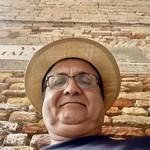

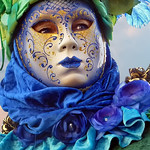

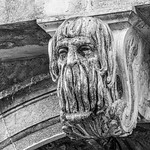

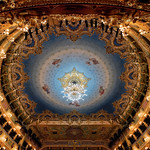

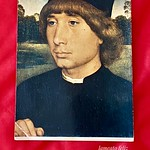

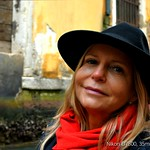

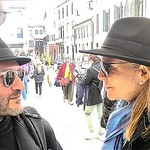

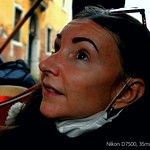

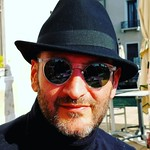

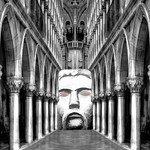

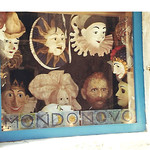

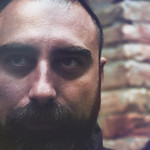

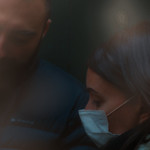

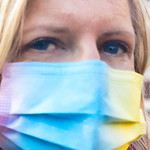

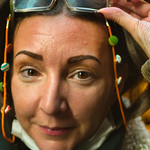

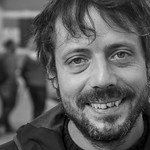

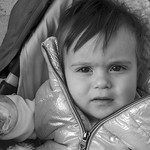

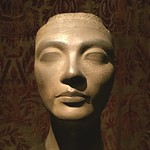

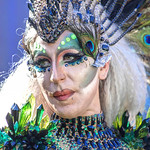

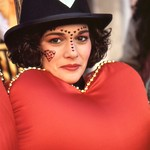

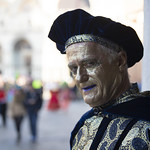

In [26]:
for name in too_much:
    img, input_img = get_one_image_name(name, all_images=all_images, images_folder=images_folder)
    display.display(img)

In [30]:
too_much = Face_pred_Suzhou[Face_pred_Suzhou['Face_ratio']>0.1].index

In [31]:
too_much

Index(['25328023607', '25328024817', '25328554617', '25345372367',
       '26343678178', '26343682938', '26785465317', '26795042127',
       '26795481867', '26965890768', '30276253228', '31020324947',
       '31660808907', '31660809667', '31971827087', '37737602334',
       '37764601374', '38888791181', '38919131931', '39855651810',
       '39948070973', '39948084753', '39948085003', '40127178304',
       '40127178994', '40127179544', '40200152481', '40200152941',
       '40200153951', '40200154771', '40835841111', '41067137225',
       '41247990174', '41429917514', '41613361962', '41663120501',
       '42368293654', '43087261171', '43949285111', '44142906250',
       '45959453801', '45998499705', '45998499875', '46912875201',
       '49173360107', '49886376816', '50150334212', '50150341542',
       '50610606631'],
      dtype='object')

In [32]:
len(too_much)

49

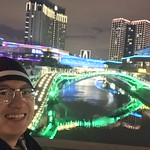

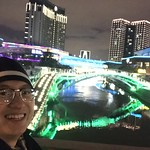

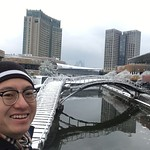

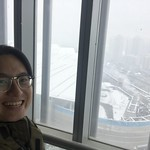

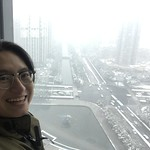

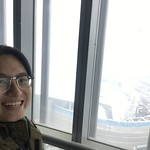

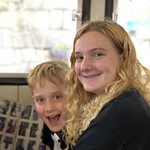

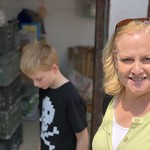

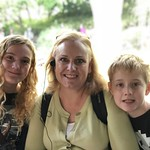

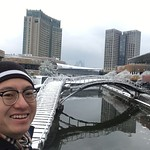

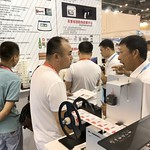

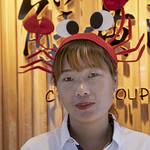

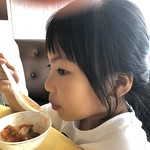

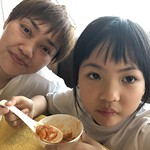

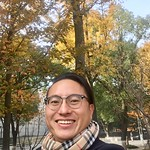

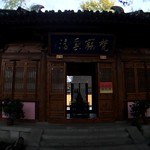

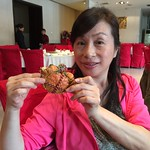

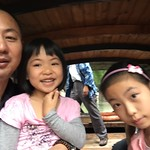

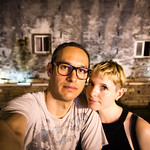

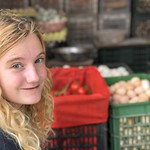

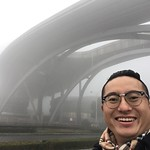

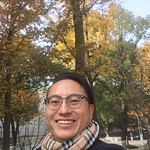

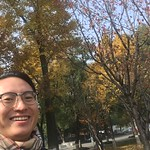

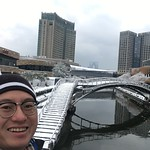

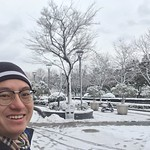

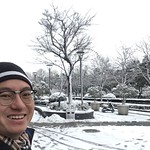

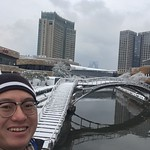

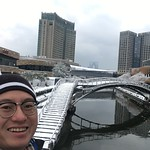

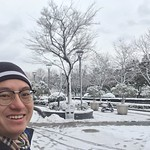

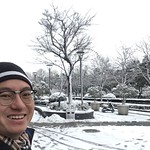

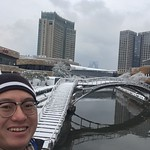

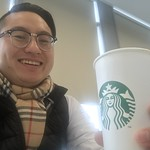

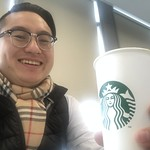

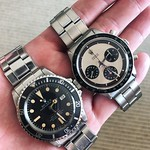

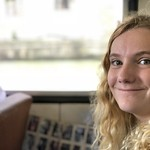

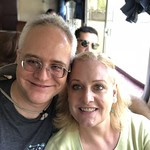

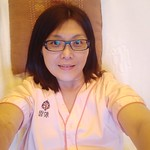

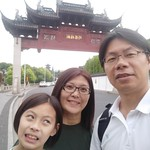

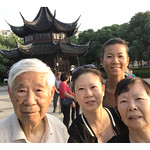

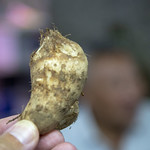

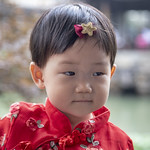

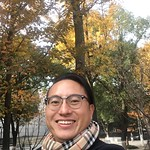

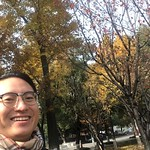

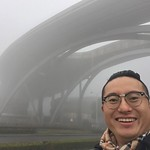

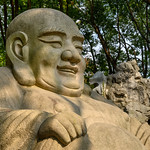

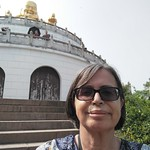

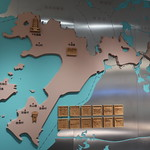

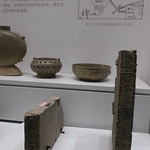

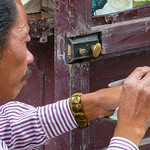

In [33]:
for name in too_much:
    img, input_img = get_one_image_name(name, all_images=all_images_Suzhou, images_folder=images_folder_Suzhou)
    display.display(img)

In [461]:
img_name, img, input_img = get_one_image(ID = 150, all_images=all_images, images_folder=images_folder)

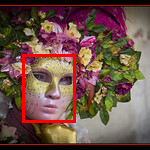

In [463]:
draw_one_image(img, input_img)

In [472]:
img_name, img, input_img = get_one_image_name('50444169667', all_images=all_images, images_folder=images_folder)

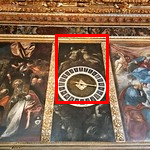

In [474]:
draw_one_image(img, input_img)

In [475]:
img_name, img, input_img = get_one_image_name('50315901403', all_images=all_images, images_folder=images_folder)

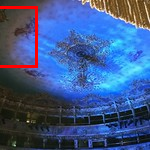

In [476]:
draw_one_image(img, input_img)

In [78]:
help(mtcnn)

Help on MTCNN in module facenet_pytorch.models.mtcnn object:

class MTCNN(torch.nn.modules.module.Module)
 |  MTCNN(image_size=160, margin=0, min_face_size=20, thresholds=[0.6, 0.7, 0.7], factor=0.709, post_process=True, select_largest=True, selection_method=None, keep_all=False, device=None)
 |  
 |  MTCNN face detection module.
 |  
 |  This class loads pretrained P-, R-, and O-nets and returns images cropped to include the face
 |  only, given raw input images of one of the following types:
 |      - PIL image or list of PIL images
 |      - numpy.ndarray (uint8) representing either a single image (3D) or a batch of images (4D).
 |  Cropped faces can optionally be saved to file
 |  also.
 |  
 |  Keyword Arguments:
 |      image_size {int} -- Output image size in pixels. The image will be square. (default: {160})
 |      margin {int} -- Margin to add to bounding box, in terms of pixels in the final image. 
 |          Note that the application of the margin differs slightly from the

In [79]:
help(mtcnn.detect)

Help on method detect in module facenet_pytorch.models.mtcnn:

detect(img, landmarks=False) method of facenet_pytorch.models.mtcnn.MTCNN instance
    Detect all faces in PIL image and return bounding boxes and optional facial landmarks.
    
    This method is used by the forward method and is also useful for face detection tasks
    that require lower-level handling of bounding boxes and facial landmarks (e.g., face
    tracking). The functionality of the forward function can be emulated by using this method
    followed by the extract_face() function.
    
    Arguments:
        img {PIL.Image, np.ndarray, or list} -- A PIL image, np.ndarray, torch.Tensor, or list.
    
    Keyword Arguments:
        landmarks {bool} -- Whether to return facial landmarks in addition to bounding boxes.
            (default: {False})
    
    Returns:
        tuple(numpy.ndarray, list) -- For N detected faces, a tuple containing an
            Nx4 array of bounding boxes and a length N list of detectio

In [83]:
display.display(x_aligned)

tensor([[[-0.1445, -0.1445, -0.1445,  ..., -0.1914, -0.1914, -0.1914],
         [-0.1445, -0.1445, -0.1445,  ..., -0.1914, -0.1914, -0.1914],
         [-0.1445, -0.1445, -0.1445,  ..., -0.1914, -0.1914, -0.1914],
         ...,
         [-0.1211, -0.1211, -0.1211,  ...,  0.2852,  0.2852,  0.2852],
         [-0.1211, -0.1211, -0.1211,  ...,  0.2852,  0.2852,  0.2852],
         [-0.1211, -0.1211, -0.1211,  ...,  0.2852,  0.2852,  0.2852]],

        [[ 0.0742,  0.0742,  0.0742,  ...,  0.1055,  0.1055,  0.1055],
         [ 0.0742,  0.0742,  0.0742,  ...,  0.1055,  0.1055,  0.1055],
         [ 0.0742,  0.0742,  0.0742,  ...,  0.1055,  0.1055,  0.1055],
         ...,
         [ 0.2773,  0.2773,  0.2773,  ...,  0.4023,  0.4023,  0.4023],
         [ 0.2773,  0.2773,  0.2773,  ...,  0.4023,  0.4023,  0.4023],
         [ 0.2773,  0.2773,  0.2773,  ...,  0.4023,  0.4023,  0.4023]],

        [[-0.5898, -0.5898, -0.5898,  ..., -0.6992, -0.6992, -0.6992],
         [-0.5898, -0.5898, -0.5898,  ..., -0

In [59]:
prob

0.99779093

In [66]:
frames_tracked = []
frame = img.copy()
boxes, _ = mtcnn.detect(frame)
frame_draw = frame.copy()
draw = ImageDraw.Draw(frame_draw)
for box in boxes:
    draw.rectangle(box.tolist(), outline=(255, 0, 0), width=3)

# Add to frame list
frames_tracked.append(frame_draw.resize((150, 150), Image.BILINEAR))

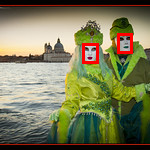

In [67]:
d = display.display(frames_tracked[0], display_id=True)
i = 1
try:
    while True:
        d.update(frames_tracked[i % len(frames_tracked)])
        i += 1
except KeyboardInterrupt:
    pass

In [69]:
boxes

array([[ 82.271255,  43.040417,  98.05905 ,  63.4478  ],
       [117.30739 ,  33.996964, 132.61516 ,  53.237537]], dtype=float32)

In [88]:
areas(boxes)[0]/(150*150)

0.027409684244791666